In [2]:
from datetime import datetime
import pandas as pd
# read a json file and return the data
def read_json_file(file_path):
    """Read a JSON file and return the data."""
    import json
    with open(file_path, 'r') as file:
        return json.load(file)

In [ ]:
# see is there data.get['section'] contains "availablity"
def has_availability_section(data):
    """Check if the data contains an 'availability' section."""
    return any('availability' in section['section'] for section in data.get('sections', []))

In [ ]:
# read all the json files in the meta directory and combine them into a single dataframe
import os
def read_all_json_files(directory):
    """Read all JSON files in a directory and return a combined DataFrame."""
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            data = read_json_file(file_path)
            if data:
                year = data.get('year')
                journal = data.get('journal')
                month = data.get('month')
                article_subtype = data.get('article_subtype')
                doi = data.get('doi')
                authors = data.get('authors', [])
                num_authors = len(authors)
                primary_institution = data.get('primary_institution')
                primary_region = data.get('primary_region')
                number_of_keywords = len(data.get('keywords', []))
                open_access = data.get('open_access')
                figure_number = data.get('figure_count')
                table_number = data.get('table_count')
                reference_count = data.get('reference_count')
                page_count = data.get('page_count')

                submission_date = data.get('submission_history', {}).get('received')
                acceptance_date = data.get('submission_history', {}).get('accepted')

                if submission_date is not None:
                    submission_date_dt = datetime.strptime(submission_date, '%Y-%m-%d')
                    acceptance_date_dt = datetime.strptime(acceptance_date, '%Y-%m-%d') if acceptance_date else None
                else:
                    submission_date_dt = None
                    acceptance_date_dt = None

                review_time_days = (acceptance_date_dt - submission_date_dt).days if submission_date_dt and acceptance_date_dt else None
                is_availability_section = has_availability_section(data)
                all_data.append({
                    'year': year,
                    'month': month,
                    'journal': journal,
                    'article_subtype': article_subtype,
                    'doi': doi,
                    'num_authors': num_authors,
                    'primary_institution': primary_institution,
                    'primary_region': primary_region,
                    'number_of_keywords': number_of_keywords,
                    'open_access': open_access,
                    'figure_number': figure_number,
                    'table_number': table_number,
                    'reference_count': reference_count,
                    'page_count': page_count,
                    'submission_date': submission_date_dt,
                    'acceptance_date': acceptance_date_dt,
                    'review_time_days': review_time_days,
                    'has_availability_section': is_availability_section
                })
    return pd.DataFrame(all_data)
df_all = read_all_json_files('../meta')
# Save the combined DataFrame to a CSV file

In [ ]:
df_all.primary_region.value_counts().sort_values(ascending=False).reset_index().rename(columns={'index': 'primary_region', 'primary_region': 'count'}).to_csv('../results/primary_region_counts.csv', index=False)

In [ ]:
#only keep the fla type 
fla = df_all[df_all['article_subtype'] == 'fla'].copy()

In [ ]:
fla.has_availability_section.value_counts()

has_availability_section
False    10675
True        49
Name: count, dtype: int64

In [3]:
fla = pd.read_csv('../fla_processing/10k_with_continent.csv')

# filter FLA to only include ones that used code
code_used_fla = fla[fla['is_code_used'] == True]

# filter fla to only include those with code publicly available
fla_code_avail = code_used_fla[code_used_fla['is_code_publicly_available'] == True]

# filter FLA to only include ones that used code
data_used_fla = fla[fla['is_data_used'] == True]

# filter fla to only include those with code publicly available
fla_data_avail = code_used_fla[code_used_fla['is_data_repository_available'] == True]

In [4]:
# group by year and journal for the data, just report the number of articles
fla_grouped = fla.groupby(['year', 'journal']).agg({
    'doi': 'count'
}).reset_index()

fla_grouped_code_used = code_used_fla.groupby(['year', 'journal']).agg({
    'doi': 'count'
}).reset_index()

fla_grouped_code = fla_code_avail.groupby(['year', 'journal']).agg({
    'doi': 'count'
}).reset_index()

fla_grouped_data_used = data_used_fla.groupby(['year', 'journal']).agg({
    'doi': 'count'
}).reset_index()

fla_grouped_data = fla_data_avail.groupby(['year', 'journal']).agg({
    'doi': 'count'
}).reset_index()

In [5]:
merged_code_fla = pd.merge(fla_grouped_code_used, fla_grouped_code, on=['journal', 'year'], how='left')
merged_code_fla['percentage_code_available'] = (merged_code_fla['doi_y'] / merged_code_fla['doi_x']) * 100

merged_data_fla = pd.merge(fla_grouped_data_used, fla_grouped_data, on=['journal', 'year'], how='left')
merged_data_fla['percentage_data_available'] = (merged_data_fla['doi_y'] / merged_data_fla['doi_x']) * 100

In [6]:
# make the jounal names more readable
fla_grouped['journal'] = fla_grouped['journal'].replace({
    'Transportation Research Part A: Policy and Practice': 'TR-A',
    'Transportation Research Part B: Methodological': 'TR-B',
    'Transportation Research Part C: Emerging Technologies': 'TR-C',
    'Transportation Research Part D: Transport and Environment': 'TR-D',
    'Transportation Research Part E: Logistics and Transportation Review': 'TR-E',
    'Transportation Research Part F: Traffic Psychology and Behaviour': 'TR-F',
    'Transportation Research Interdisciplinary Perspectives': 'TR-IP'
})

merged_code_fla['journal'] = merged_code_fla['journal'].replace({
    'Transportation Research Part A: Policy and Practice': 'TR-A',
    'Transportation Research Part B: Methodological': 'TR-B',
    'Transportation Research Part C: Emerging Technologies': 'TR-C',
    'Transportation Research Part D: Transport and Environment': 'TR-D',
    'Transportation Research Part E: Logistics and Transportation Review': 'TR-E',
    'Transportation Research Part F: Traffic Psychology and Behaviour': 'TR-F',
    'Transportation Research Interdisciplinary Perspectives': 'TR-IP'
})

merged_data_fla['journal'] = merged_data_fla['journal'].replace({
    'Transportation Research Part A: Policy and Practice': 'TR-A',
    'Transportation Research Part B: Methodological': 'TR-B',
    'Transportation Research Part C: Emerging Technologies': 'TR-C',
    'Transportation Research Part D: Transport and Environment': 'TR-D',
    'Transportation Research Part E: Logistics and Transportation Review': 'TR-E',
    'Transportation Research Part F: Traffic Psychology and Behaviour': 'TR-F',
    'Transportation Research Interdisciplinary Perspectives': 'TR-IP'
})

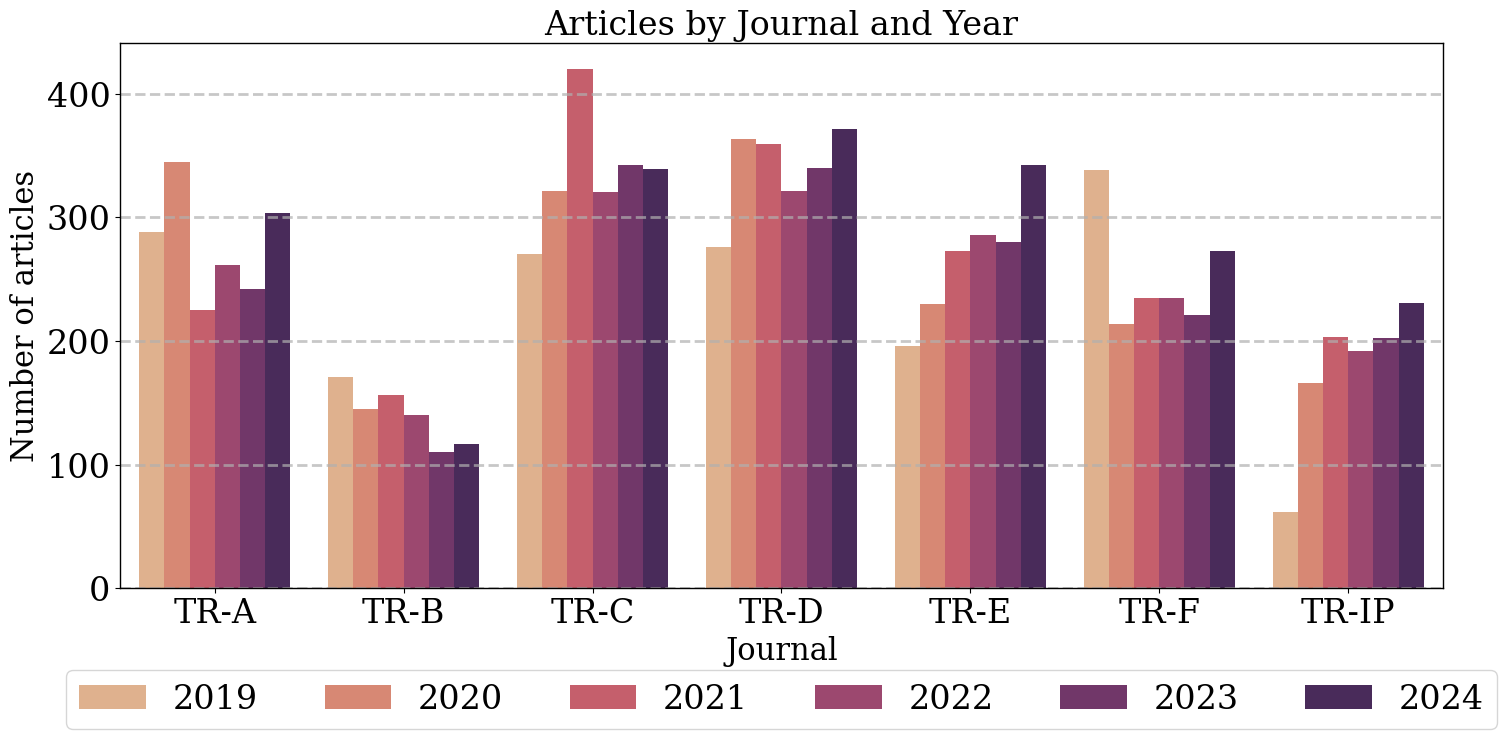

In [7]:
# Set the desired journal order
journal_order = ['TR-A', 'TR-B', 'TR-C', 'TR-D', 'TR-E', 'TR-F', 'TR-IP']
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 24  # Set default font size larger

plt.figure(figsize=(16, 8))

ax = sns.barplot(
    data=fla_grouped,
    x='journal',
    y='doi',
    hue='year',
    order=journal_order,
    palette='flare'
)

ax.set_xlabel("Journal", fontsize=22, family='serif')
ax.set_ylabel("Number of articles", fontsize=22, family='serif')

plt.title("Articles by Journal and Year", fontsize=24, family='serif')

plt.xticks(rotation=0, fontsize=24, family='serif')
plt.yticks(fontsize=24, family='serif')

plt.legend(
    bbox_to_anchor=(0.5, -0.12),
    loc='upper center',
    ncol=6,
    prop={'family': 'serif', 'size': 24}
)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7, linewidth=2)

# Make the box (spines) black
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

plt.savefig('../figures/journal_article_year.pdf', dpi=300)
